<a href="https://colab.research.google.com/github/p1306/Leaf-Analysis-Project/blob/main/TomatoPlant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ImageSize = 256
BatchSize = 32
channels = 3
epochs = 20

In [ ]:
data = tf.keras.preprocessing.image_dataset_from_directory(
        "/content/drive/MyDrive/PlantVillage/Tomato_images",
        shuffle=True,
        image_size=(ImageSize, ImageSize),
        batch_size=BatchSize
)

Found 4848 files belonging to 7 classes.


In [ ]:
class_names = data.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato_healthy']

In [ ]:
for image_batch, labels_batch in data.take(1):
      print(image_batch.shape)
      print(labels_batch.numpy())

(32, 256, 256, 3)
[4 6 0 0 5 2 1 2 0 0 2 0 6 4 0 0 1 2 6 5 2 6 4 1 5 5 0 0 0 1 1 5]


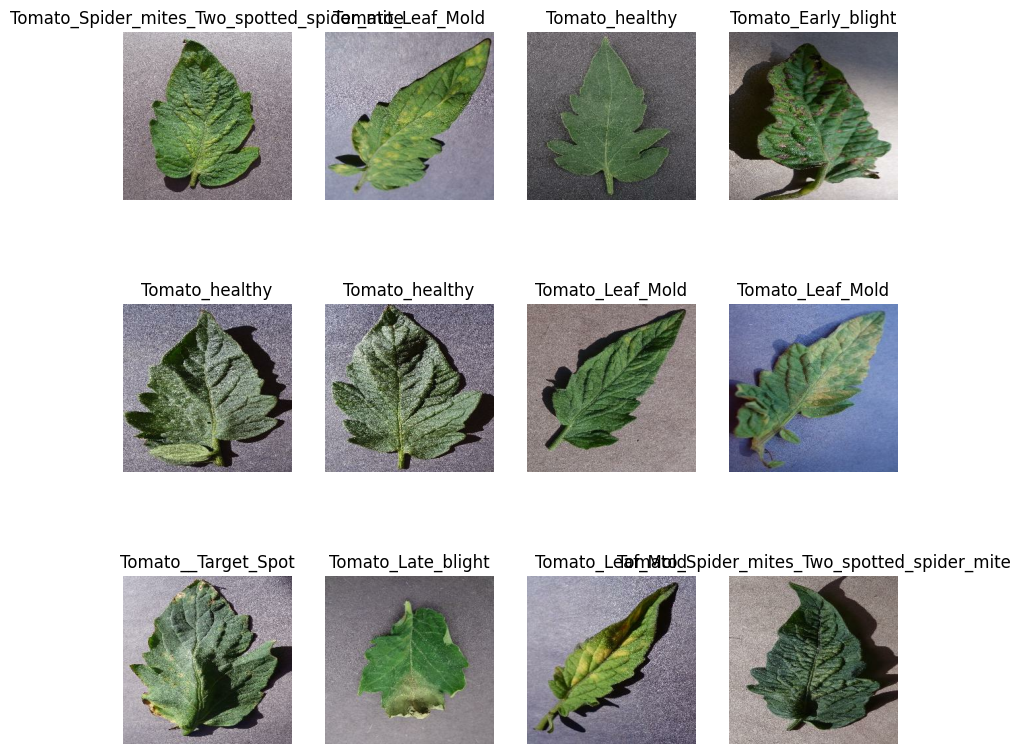

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in data.take(1):
    for i in range(12):
            ax = plt.subplot(3, 4, i + 1)
            plt.imshow(image_batch[i].numpy().astype("uint8"))
            plt.title(class_names[labels_batch[i]])
            plt.axis("off")

In [ ]:
train_size = 0.6
len(data)*train_size

91.2

In [ ]:
train_data = data.take(91)
len(train_data)

91

In [ ]:
test = data.skip(91)
len(test)

61

In [ ]:
val_size = 0.3
len(data)*val_size

45.6

In [ ]:
val_data = test.take(46)
len(val_data)

46

In [ ]:
test_data = test.skip(46)
len(test_data)

15

In [ ]:
def train_test_split(ds, train_split=0.6, val_split=0.3, test_split=0.1, shuffle=True, shuffle_size=10000):
      assert (train_split + test_split + val_split) == 1

      ds_size = len(ds)

      if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

      train_size = int(train_split * ds_size)
      val_size = int(val_split * ds_size)

      train_ds = ds.take(train_size)
      val_ds = ds.skip(train_size).take(val_size)
      test_ds = ds.skip(train_size).skip(val_size)

      return train_ds, val_ds, test_ds

In [ ]:
train_data, val_data, test_data = train_test_split(data)

In [ ]:
print(len(train_data), len(val_data), len(test_data))

91 45 16


In [ ]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
      layers.Resizing(ImageSize, ImageSize),
      layers.Rescaling(1.0 / 255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.2)
])

In [ ]:
train_data = train_data.map(
      lambda x, y: (data_augmentation(x, training=True), y)
      ).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape = (BatchSize, ImageSize, ImageSize, channels)
n_classes = 7

In [ ]:
model = models.Sequential([
    layers.Input(shape=(ImageSize, ImageSize, channels)),
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 184,007 (718.78 KB)

 Trainable params: 184,007 (718.78 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
      optimizer='adam',
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
      metrics=['accuracy']
)

In [ ]:
history = model.fit(
      train_data,
      batch_size=BatchSize,
      validation_data=val_data,
      verbose=1,
      epochs=20,
)

Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2071s 5s/step - accuracy: 0.2594 - loss: 1.8651 - val_accuracy: 0.4701 - val_loss: 1.3954
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 481s 5s/step - accuracy: 0.5298 - loss: 1.2721 - val_accuracy: 0.3625 - val_loss: 1.8314
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 485s 5s/step - accuracy: 0.6214 - loss: 0.9623 - val_accuracy: 0.6125 - val_loss: 1.0043
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 482s 5s/step - accuracy: 0.6820 - loss: 0.8680 - val_accuracy: 0.5972 - val_loss: 1.2207
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 476s 5s/step - accuracy: 0.7257 - loss: 0.7174 - val_accuracy: 0.6368 - val_loss: 1.0374
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 474s 5s/step - accuracy: 0.7218 - loss: 0.7609 - val_accuracy: 0.5396 - val_loss: 1.5917
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 470s 5s/step - accuracy: 0.7713 - loss: 0.6065 - val_accuracy: 0.4458 - val_loss: 1.9861
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 470s 5s/step - accuracy: 0.7746 - loss: 0.6081 - val_accuracy: 0.6493 - 

In [ ]:
scores = model.evaluate(test_data)
history.params
history.history['loss'][:5] # show loss for first 5 epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

16/16 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.8106 - loss: 0.6020


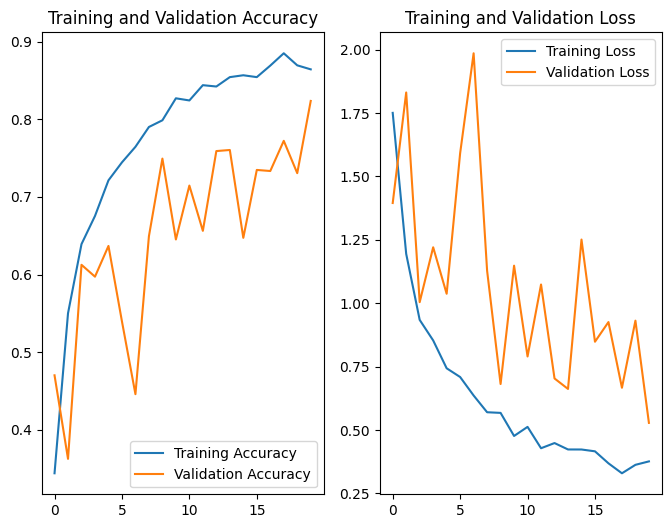

In [ ]:
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


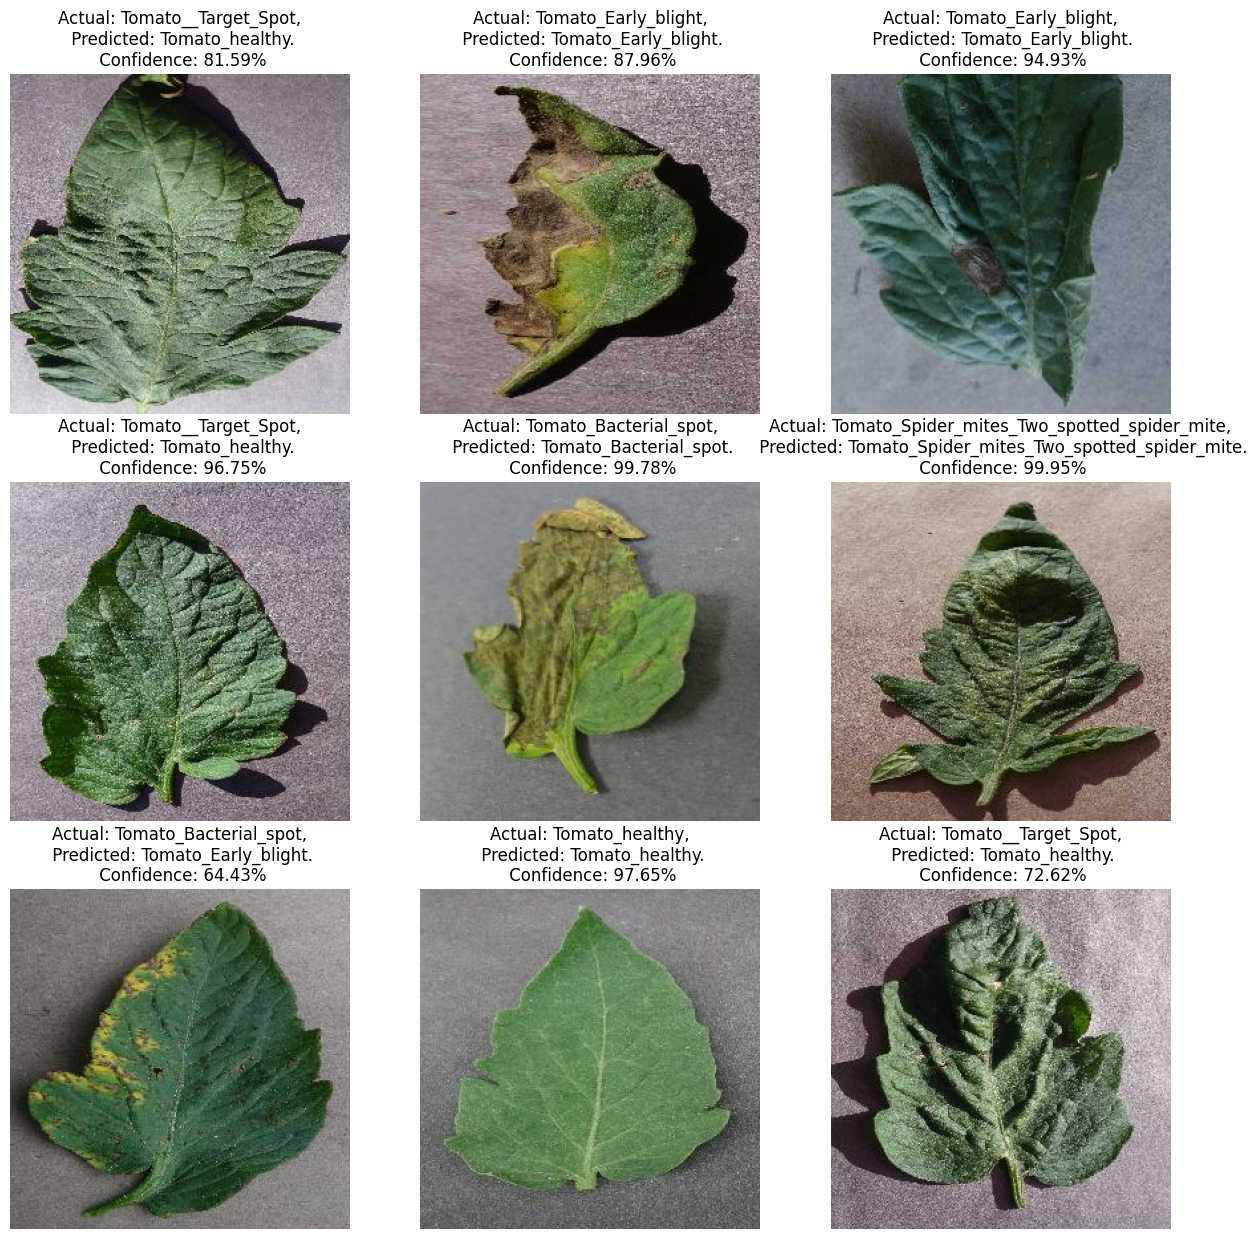

In [ ]:
import numpy as np
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence
plt.figure(figsize=(15, 15))
for images, labels in test_data.take(1):
    for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))

            predicted_class, confidence = predict(model, images[i].numpy())
            actual_class = class_names[labels[i]]

            plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

            plt.axis("off")

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8189 - loss: 0.5232
Test Accuracy: 81.84%


In [ ]:
# Confusion Matrix
y_true = []
y_pred = []

for images, labels in test_data:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Confusion Matrix:
 [[102  13   0   0  14   3   0]
 [  2  41   5   0   6   1   0]
 [  3   4  51   4   5   0   1]
 [  0   0   1  44   2   1   0]
 [  0   0   0   0  87   2   8]
 [  0   0   0   0   5  36  13]
 [  0   0   0   0   0   0  58]]


In [ ]:
from sklearn.metrics import classification_report

# Classification Report
class_report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", class_report)

Classification Report:
                                              precision    recall  f1-score   support

                      Tomato_Bacterial_spot       0.95      0.77      0.85       132
                        Tomato_Early_blight       0.71      0.75      0.73        55
                         Tomato_Late_blight       0.89      0.75      0.82        68
                           Tomato_Leaf_Mold       0.92      0.92      0.92        48
Tomato_Spider_mites_Two_spotted_spider_mite       0.73      0.90      0.81        97
                        Tomato__Target_Spot       0.84      0.67      0.74        54
                             Tomato_healthy       0.72      1.00      0.84        58

                                   accuracy                           0.82       512
                                  macro avg       0.82      0.82      0.81       512
                               weighted avg       0.84      0.82      0.82       512



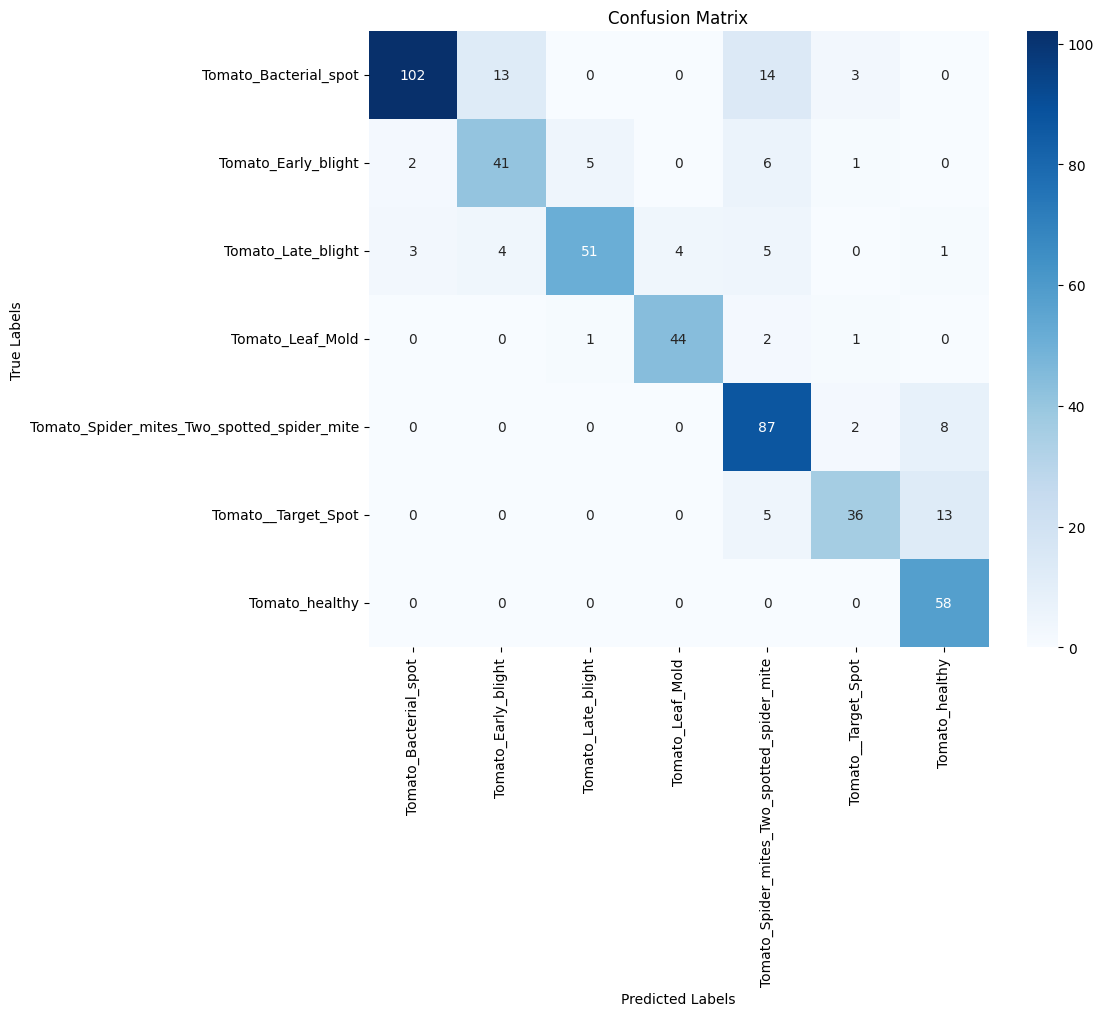

In [ ]:
# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()